<a href="https://colab.research.google.com/github/morwald/ada_project/blob/main/Copy_of_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Female citations in UKs leading news papers

This notebook serves as a first presentation of our project for milestone 2. It is structured and written in such  a way that we can directly continue on it for milestone 3.

## Content
1. [Setup](#setup)   
    1.1 [Imports](#imports)  
    1.2 [Data paths](#data_paths)   
    1.3 [Utility functions](#utility_functions)   
2. [Data preparation](#data_prep)    
    2.1 [Columns and rows selection](#cols_rows_select)  
    2.2 [News paper selection](#newspaper_select)           
    2.3 [Filtering raw data](#filter_raw_data)

3. [Additional data set: speaker attributes](#speaker_attr)    
    3.1 [Explore attributes](#explore_attr)  
    3.2 [Retrieve quotebank wikidata labels](#reatrieve_labels)           
    3.3 [Filtering raw data](#filter_raw_data)   

4. [Data exploration and cleaning](#data_explore_clean)  
    4.1 [Import prepared data](#import_prep_data)   
    4.2 [Set index](#set_index)    
    4.3 [Save cleaned data frame as pickle](#save_pickle)   
5. [Research questions](#research_question)     
    5.1 [Load pickled dataframes](#load_pickle)

## 1. Setup
<a id="setup"></a>

### 1.1 Imports
<a id="imports"></a>

In [ ]:
import pandas as pd
import numpy as np
import json
import bz2
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter

### 1.2 Data paths
<a id="Data paths"></a>

**Important**: The raw and prepared data are stored locally in the root folder _Quotebank_ and _Filtered data_. To execute section [Data preperation](#data_prep) the raw data in the folder _Quotebank_ is needed. This section has to be executed only once. When using Google Colab the ```use_colab``` variable has to be set to true. This way the paths can be access directly from our shared drive.

You can download the raw data here (EPFL google account required): [Quotebank](), [Speakers]() \
The cleaned data can be found using this link:
[Cleaned data]()

In [ ]:
# Comment the files which aren't locally stored
# In Colab everything should be available
RAW_QUOTES_2020_PATH = 'Quotebank/quotes-2020.json.bz2' 
QUOTES_2020_PATH = 'Filtered data/quotes-2020-gb.json.bz2' 

#RAW_QUOTES_2019_PATH = 'Quotebank/quotes-2019.json.bz2' 
QUOTES_2019_PATH = 'Filtered data/quotes-2019-gb.json.bz2' 

#RAW_QUOTES_2018_PATH = 'Quotebank/quotes-2018.json.bz2' 
QUOTES_2018_PATH = 'Filtered data/quotes-2018-gb.json.bz2' 

#RAW_QUOTES_2017_PATH = 'Quotebank/quotes-2017.json.bz2' 
QUOTES_2017_PATH = 'data/quotes-2017-gb.json.bz2' 

#RAW_QUOTES_2016_PATH = 'raw_data/quotes-2016.json.bz2' 
QUOTES_2016_PATH = 'data/quotes-2016-gb.json.bz2' 

#RAW_QUOTES_2015_PATH = 'raw_data/quotes-2015.json.bz2' 
QUOTES_2015_PATH = 'data/quotes-2015-gb.json.bz2'

# Additional data set
SPEAKER_ATTRIBUTES_PATH = 'Project datasets/speaker_attributes.parquet'
LABELS_WIKIDATA_PATH = 'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'

In [ ]:
# Change to True if you want to use google colab
use_colab = True

We mount the drive and go to the right directory.

In [ ]:
# Import epfl google drive!
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    %cd /content/drive/Shareddrives/ADA-project

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


We have to install an older version of pandas in order to be able to use the 'chunksize' feature in colab.

In [ ]:
if use_colab:
    !pip install pandas==1.0.5

    # Reimport
    import pandas as pd
    print(pd.__version__)

     |████████████████████████████████| 10.1 MB 5.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


1.1.5


## 1.3 Utility functions
<a id="utility_functions"></a>

In [ ]:
def load_mini_version_of_data(path_to_file, chunksize, nb_chunks):
    """
    Returns a mini dataframe from of a bz2 compressed json file.
    :path_to_file: file path as string
    :chunksize: size to iterate
    :nb_chunks: how many chunks
    :return: pandas.DataFrame with chunksize*nb_chunks of rows
    """
    
    curr_chunk = 0
    chunk_list = []
    
    if use_colab:
          for chunk in pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize):
              if curr_chunk == nb_chunks:
                  break
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    else:
      with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
          for chunk in df_reader:
              if curr_chunk == nb_chunks:
                  break
          
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    
    df = pd.concat(chunk_list)
    return df

## 2. Data preparation
<a id="data_prep"></a>

The quotebank dataset is too large to directly access it with a dataframe. This section provides all the steps to filter the data we need for our analysis. The filtering and preperation is done based on our research question. Please check the README for details. Further explanations are given under [Research question](#research_question).

The data preperation can be done on a per year basis of the Quotebank data set.

### 2.1 Column and row selection
<a id="cols_rows_select"></a>

In [ ]:
# A quick look at a small subset of the data of the selected year
year_sample_df = load_mini_version_of_data(RAW_QUOTES_2020_PATH, 10000, 10)
year_sample_df.head()

In [ ]:
# How many quotations don't have an assigned speaker?
sum(year_sample_df['speaker'] == 'None')

34316

The cell above shows that there around 1/3 of the quotations are 'None' speakers. As we want to make a gender based study will will not need these rows. This eliminitation will drasticly reduce the size of the data we have to analyse.

Furthermore the colums which aren't of interest for our study are:\
**phase**: we don't care\
**probas**: as we will select the the speaker with highest probablity (note that 'None' speakers are already neglected)

### 2.2 Newspaper selection
<a id="nespaper_select"></a>
In first analysis we will pick quotations of 3 of the top 12 UKs newspapers with the most reach both in prints and digital reach. See [this]() statistic for further details

In [ ]:
# List of selected newspapers and their urls
newspapers_list = [['The Sun', 'thesun.co.uk'], 
                  ['The Guardian', 'theguardian.com'],
                  ['The Times', 'thetimes.co.uk']]

# Dataframe
newspapers_df = pd.DataFrame(newspapers_list, columns = ['name', 'website_url'])
newspapers_df.head()

### 2.3 Filtering raw data
<a id="filter_raw_data"></a>

Following the reasoning above we can extract the infos needed from the compressed file of a year of quotations. Let's create a helper function to check the primary urls of a quotation:

In [ ]:
def filter_data(path_in, path_out):
  # Loop through all instances of json file and extract the desired rows
  # Save the file in the data directory
  with bz2.open(path_in, 'rb') as s_file:
      with bz2.open(path_out, 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              if instance['speaker'] == 'None':
                  continue
              urls = instance['urls'] # extracting list of links
              newspapers = []
              for url in urls:
                  for name, website_url in zip(newspapers_df['name'],newspapers_df['website_url']):
                      if website_url in url:
                          newspapers.append(name)
                          instance['newspapers'] = newspapers # updating the sample with domain name
              # We remove unnecessary columns
              instance.pop('probas')
              instance.pop('phase')
              # If there is a newspaper that we want to keep we write the instance to the output file
              if newspapers: 
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                

In [ ]:
#filter_data(RAW_QUOTES_2020_PATH,QUOTES_2020_PATH)

In [ ]:
# We check that the new file contains the right data
filtered_sample_df = load_mini_version_of_data(QUOTES_2020_PATH, 10000, 10)
filtered_sample_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[Q304349],2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,"[Q20670776, Q20713880, Q7803899, Q7803900]",2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[Q242329],2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[Q5231515],2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,"[Q30693403, Q43130877]",2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


Let's check that there are no 'None' speakers:

In [ ]:
filtered_sample_df[filtered_sample_df.speaker=='None'].empty

True

#### Replace qids column by only taking its first qid value 

In [ ]:
#We want to transform the 'qids' column in a single 'qid' element
def get_single_qid(df_quotes):

  df_copy =  df_quotes.copy()
  df_result =  df_quotes.copy()
  for idx,row in df_copy.iterrows():  
    id_speaker = row.loc['qids'][0] 
    df_result.at[idx,'qids'] = id_speaker

  df_result = df_result.rename(columns={"qids": "qid"})
  return df_result

In [ ]:
filtered_sample_df = get_single_qid(filtered_sample_df)

Now let us do this filtering for the remaining data of years 2015-2019.

In [ ]:
#filter_data(RAW_QUOTES_2019_PATH,QUOTES_2019_PATH)
#filter_data(RAW_QUOTES_2018_PATH,QUOTES_2018_PATH)
#filter_data(RAW_QUOTES_2017_PATH,QUOTES_2017_PATH)
#filter_data(RAW_QUOTES_2016_PATH,QUOTES_2016_PATH)
#filter_data(RAW_QUOTES_2015_PATH,QUOTES_2015_PATH)

## 3. Additional data set: speaker attributes
<a id="speaker_attr"></a>

The filtered Quotebank years are ready. The next step consists of integrating speaker attributes from our additional data set.

### 3.1 Explore attributes
<a id="explore_attr"></a>


In [ ]:
# Load speaker attributes in df
speakers_df = pd.read_parquet(SPEAKER_ATTRIBUTES_PATH)
speakers_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


We would like to do an analysis based on the gender of the speakers. Thus we are not interested in the quotes without a speaker. We first proceed to remove them.


In [ ]:
# Fraction of lines with null gender : 
speakers_df[speakers_df.gender.isnull()].size / speakers_df.size

0.21536937853557775

In [ ]:
# Remove null gender
speakers_df = speakers_df.drop(speakers_df[speakers_df.gender.isnull()].index)

We aren't intersted in a lot of those columns. First of we'll remove all the unneccessary ones for our analysis.

In [ ]:
# Remove unncessary columns
speakers_df = speakers_df.drop(['lastrevid', 'US_congress_bio_ID', 'party', 'candidacy', 'type'], axis=1) 
#TODO Garder ici déjà que id, gender et nationality? Ou faire quand même l'analyse

And there seem to be no duplicates. Perfect.

In [ ]:
# Duplicates
duplicates = speakers_df[speakers_df.duplicated(subset='id', keep='first')] 
duplicates.head()

,aliases,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label,religion


In addition to the gender column, we are also interested in the columns academic_degree and nationality. Let's check how many 'None' values we have and remove them.

In [ ]:
# Fraction of lines with null nationality
speakers_df[speakers_df.nationality.isnull()].size / speakers_df.size

0.48707104255798245

In [ ]:
# Fraction of lines with null academic degree :
speakers_df[speakers_df.academic_degree.isnull()].size / speakers_df.size

0.9866371594235532

In [ ]:
# Fraction of lines with null date of birth
speakers_df[speakers_df.date_of_birth.isnull()].size / speakers_df.size

0.31948139495609096

In [ ]:
# Fraction of lines with null ethnic_group
speakers_df[speakers_df.ethnic_group.isnull()].size / speakers_df.size

0.9819298862868723

In [ ]:
# Fraction of lines with null religion
speakers_df[speakers_df.religion.isnull()].size / speakers_df.size

0.9727195451474893

In [ ]:
# Fraction of lines with null label
speakers_df[speakers_df.label.isnull()].size / speakers_df.size

0.055411365683404636

We will keep only columns for gender and nationality

In [ ]:
speakers_df = speakers_df[['id', 'gender', 'nationality']]

In [ ]:
speakers_df.head()

,id,gender,nationality
0,Q23,[Q6581097],"[Q161885, Q30]"
1,Q42,[Q6581097],[Q145]
2,Q1868,[Q6581097],[Q31]
3,Q207,[Q6581097],[Q30]
4,Q297,[Q6581097],[Q29]


In [ ]:
#Create dict of genders, nationalities
genders_dict = pd.Series(speakers_df.gender.values, index=speakers_df.id).to_dict()
nationalities_dict = pd.Series(speakers_df.nationality.values, index=speakers_df.id).to_dict()

### 3.2 Retrieve quotebank wikidata labels
<a id="reatrieve_labels"></a>



In [ ]:
labels = pd.read_csv(LABELS_WIKIDATA_PATH, compression='bz2', index_col='QID')
labels.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


Let's see what the fraction of NaN labels is

In [ ]:
labels.Label.isnull().count()/labels.size

0.5

In [ ]:
#Create dict of labels
labels_dict = pd.Series(labels.Label, index=labels.index)

### Create dictionary between id_speaker and the value of attributes gender and nationality

In [ ]:
# Retrieve quotes speakers' attribute, in the order of the quotations df
# Input : df_quotes with only first qid in new column qid (instead of qids)
def list_attribute_speaker(id_speaker, attr_dict):
  list_attr = []
  #id_attr_speaker = df_3.loc[df_3.id==id_speaker][attr].to_numpy() #List of all attribute ID per speaker
  if id_speaker in attr_dict:
    id_attr_speaker = attr_dict[id_speaker]
    if(id_attr_speaker is not None):
      for id_a in id_attr_speaker:
          attr= labels_dict[id_a] #Attribute value
          list_attr.append(attr)
    #else :
      #list_attr.append(None)
  return list_attr

In [ ]:
dict_genders = {}
dict_genders = dict(filtered_sample_df['qid'].apply(lambda i: list_attribute_speaker(i, genders_dict)).tolist())

Let's put everything together to get this for all of our quotes :

In [ ]:
import json
from tqdm.notebook import tqdm_notebook
import time

def add_speaker_info(path_in):
  df = pd.read_json(path_in, lines=True,compression='bz2')
  #first we get a single qid:
  df = get_single_qid(df)
  tqdm_notebook.pandas()
  genders = df['qid'].progress_apply(lambda i: list_attribute_speaker(i, genders_dict))
  nationalities = df['qid'].progress_apply(lambda i: list_attribute_speaker(i, nationalities_dict))
  df.insert(3, 'gender', genders)
  df.insert(4,'nationality', nationalities)
  return df

In [ ]:
df_2020 = add_speaker_info(QUOTES_2020_PATH)

  0%|          | 0/26070 [00:00<?, ?it/s]

  0%|          | 0/26070 [00:00<?, ?it/s]

In [ ]:
df_2019 = add_speaker_info(QUOTES_2019_PATH)

  0%|          | 0/103315 [00:00<?, ?it/s]

  0%|          | 0/103315 [00:00<?, ?it/s]

In [ ]:
df_2020.head()

,quoteID,quotation,speaker,gender,nationality,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],[],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],[],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


###Test and first exploration with the 2019 New York Times Data 

We first looked at the sample with quotes from the 2019 NewYork Times data for an easier overall observation

In [ ]:
df_quotesNY = pd.read_json('quotes-2019-nytimes.json', lines=True)
df_quotesNY.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E


In [ ]:
#Filter null speaker 
df_quotesNY = df_quotesNY.drop(df_quotesNY[df_quotesNY.speaker == 'None'].index)
df_quotesNY.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
5,2019-08-15-002017,A Senator we can call our own.,Tom Rath,[Q7817334],2019-08-15 22:36:33,1,"[[Tom Rath, 0.7598], [None, 0.1993], [Warren R...",[http://www.nytimes.com/2019/08/15/us/politics...,E
8,2019-07-22-032883,"It's a success, a relief and a technical feat,",Florence Parly,[Q3074013],2019-07-22 02:37:50,21,"[[Florence Parly, 0.9262], [None, 0.0738]]",[http://www.breitbart.com/news/french-submarin...,E


We would like to determine the number of genders present in the the data.

In [ ]:
speaker_genders = speakers_df['gender']
speaker_genders.value_counts()

[Q6581097]              5418464
[Q6581072]              1684170
[Q1052281]                  887
[Q48270]                    307
[Q2449503]                  228
                         ...   
[Q6581097, Q6581072]          1
[Q179294, Q6581097]           1
[Q179294, Q6581097]           1
[Q179294, Q6581097]           1
[Q6581097, Q6581072]          1
Name: gender, Length: 1411, dtype: int64

We print the different registered genders :

In [ ]:
print(labels.loc['Q6581097']['Label'],
      labels.loc['Q6581072']['Label'],
      labels.loc['Q1052281']['Label'],
      labels.loc['Q48270']['Label'],
      labels.loc['Q2449503']['Label'])

male female transgender female non-binary transgender male


We create a function to extract the gender and nationality labels for each speaker QID. To make it more efficient, we store in a dictionary a mapping from the attributes' qids to their labels, so we don't need to search for it in the label dataframe everytime.

In [ ]:
all_attributes = {}

In [ ]:
#Goal : struct dictionary{key = quote_id, value = ([genders],[nationalities])}

# Retrieve quotes speakers' gender, in the order of the quotations df
# Input : df_quotes with only first qid in new column qid (instead of qids)
def list_attribute_speaker(id_speaker, attr):
  list_attr = []
  id_attr_speaker = speakers_df.loc[speakers_df.id==id_speaker][attr] #List of all attribute ID per speaker
  for id_a in id_attr_speaker:
     if(id_a is not None):
       attr = all_attributes.get(id_a[0])
       if attr is None:
         attr= labels.loc[id_a]['Label'].values #Attribute value
         all_attributes[id_a[0]] = attr
       list_attr.append(attr[0]) 
  return list_attr

Next we create a function to pick the first qid in the list of aliases in order to map each quote with a single speaker qid. We decided to pick the first one of the list as the choice should not influence too much on the gender of the speaker.

In [ ]:
#We want to transform the 'qids' column in a single 'qid' element
def get_single_qid(df_quotes):

  df_copy =  df_quotes.copy()
  df_result =  df_quotes.copy()
  for idx,row in df_copy.iterrows():  
    id_speaker = row.loc['qids'][0] 
    df_result.at[idx,'qids'] = id_speaker

  df_result = df_result.rename(columns={"qids": "qid"})
  return df_result

In [ ]:
#we extract a single qid for our dataset
df_quotesNY_qid = get_single_qid(df_quotesNY)

Now we apply our function to get a dictionary mapping each speaker id to their gender and nationality.

In [ ]:
test_quotesNY = df_quotesNY_qid.head(10)
list_genders = test_quotesNY['qid'].apply(lambda i: list_attribute_speaker(i, 'gender'))
list_genders

0       [male]
1       [male]
3       [male]
5       [male]
8     [female]
10      [male]
12      [male]
13    [female]
14      [male]
15      [male]
Name: qid, dtype: object

In [ ]:
list_nat = test_quotesNY['qid'].apply(lambda i: list_attribute_speaker(i, 'nationality'))
list_nat

0               [United Kingdom]
1     [United States of America]
3     [United States of America]
5     [United States of America]
8                       [France]
10    [United States of America]
12    [United States of America]
13    [United States of America]
14              [United Kingdom]
15    [United States of America]
Name: qid, dtype: object

Next we add this information in two new columns.

In [ ]:
test_quotesNY.insert(3, 'gender', list_genders)
test_quotesNY.insert(4,'nationality', list_nat)
test_quotesNY.head()

,quoteID,quotation,speaker,gender,nationality,qid,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,[male],[United Kingdom],Q16213953,2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[male],[United States of America],Q105756,2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[male],[United States of America],Q1855840,2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
5,2019-08-15-002017,A Senator we can call our own.,Tom Rath,[male],[United States of America],Q7817334,2019-08-15 22:36:33,1,"[[Tom Rath, 0.7598], [None, 0.1993], [Warren R...",[http://www.nytimes.com/2019/08/15/us/politics...,E
8,2019-07-22-032883,"It's a success, a relief and a technical feat,",Florence Parly,[female],[France],Q3074013,2019-07-22 02:37:50,21,"[[Florence Parly, 0.9262], [None, 0.0738]]",[http://www.breitbart.com/news/french-submarin...,E


## 4 Research questions and understanding
<a id="data_explore_clean"></a>

We first concentrate on the 2020 augmented data for the exploration and cleaning.

In [ ]:
augmented_df = df_2020
augmented_df

,quoteID,quotation,speaker,gender,nationality,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],[],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],[],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]
...,...,...,...,...,...,...,...,...,...,...
26065,2020-02-18-060949,Or if you have a pension coming in or a second...,MARTIN Lewis,[male],[United States of America],Q16151827,2020-02-18 11:16:35,1,[https://www.thesun.co.uk/money/10985339/marti...,[The Sun]
26066,2020-03-12-066445,The simplicity of this jumpsuit makes it look ...,David Cummings,[male],[United States of America],Q22236639,2020-03-12 21:42:24,1,[https://www.thesun.co.uk/fabulous/11162600/st...,[The Sun]
26067,2020-01-24-089401,They want to get to the moon in 2024.,Laura Tobin,[female],[United Kingdom],Q6499505,2020-01-24 07:18:46,1,[https://www.thesun.co.uk/tvandshowbiz/1081013...,[The Sun]
26068,2020-01-14-105950,"Yesterday, I was walking around my home town w...",Quique Setien,[male],[Spain],Q2444534,2020-01-14 11:14:22,187,[http://sportsmole.co.uk/football/barcelona/ne...,[The Guardian]


### 4.1 Data cleaning
<a id="import_prep_data"></a>

We first concentrate on the 2020 augmented data for the exploration and cleaning.

In [ ]:
augmented_df = df_2020
augmented_df

,quoteID,quotation,speaker,gender,nationality,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],[],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],[],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]
...,...,...,...,...,...,...,...,...,...,...
26065,2020-02-18-060949,Or if you have a pension coming in or a second...,MARTIN Lewis,[male],[United States of America],Q16151827,2020-02-18 11:16:35,1,[https://www.thesun.co.uk/money/10985339/marti...,[The Sun]
26066,2020-03-12-066445,The simplicity of this jumpsuit makes it look ...,David Cummings,[male],[United States of America],Q22236639,2020-03-12 21:42:24,1,[https://www.thesun.co.uk/fabulous/11162600/st...,[The Sun]
26067,2020-01-24-089401,They want to get to the moon in 2024.,Laura Tobin,[female],[United Kingdom],Q6499505,2020-01-24 07:18:46,1,[https://www.thesun.co.uk/tvandshowbiz/1081013...,[The Sun]
26068,2020-01-14-105950,"Yesterday, I was walking around my home town w...",Quique Setien,[male],[Spain],Q2444534,2020-01-14 11:14:22,187,[http://sportsmole.co.uk/football/barcelona/ne...,[The Guardian]


In [ ]:
# Get the types of the columns
augmented_df.dtypes

quoteID                   object
quotation                 object
speaker                   object
gender                    object
nationality               object
qid                       object
date              datetime64[ns]
numOccurrences             int64
urls                      object
newspapers                object
dtype: object

In [ ]:
# Full descritpion of the numerical data
augmented_df.describe()

,numOccurrences
count,26070.000000
mean,9.577484
std,41.897187
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,2037.000000


The only numerical data we get is the number of occurences. We only get a meaningful description for this column yet.

We then want to check about any missing values or other anomalies in the data.

In [ ]:
# Verification for null values
augmented_df.isnull().any()

quoteID           False
quotation         False
speaker           False
gender            False
nationality       False
qid               False
date              False
numOccurrences    False
urls              False
newspapers        False
dtype: bool

In [ ]:
# Verification of empty quotes
augmented_df[augmented_df.quotation == '']

,quoteID,quotation,speaker,gender,nationality,qid,date,numOccurrences,urls,newspapers


In [ ]:
# Verification of duplicates
duplicates = augmented_df[augmented_df.duplicated(subset='quoteID', keep='first')] 
duplicates.head()

,quoteID,quotation,speaker,gender,nationality,qid,date,numOccurrences,urls,newspapers


We achieved the sanity check. There are no missing values nor duplicates. We can try a visualisation for the understanding of our data.

### 4.2 Visualisation of genders
<a id="set_index"></a>

We want to base our anylsis on the gender of the speakers. The visualisation will be concentrated on their repartition.

In [ ]:
# Convert the 2D gender column to 1D
def convert(series):
  return pd.Series([x for _list in series for x in _list])

In [ ]:
# Get number of each gender
convert(augmented_df["gender"]).value_counts()

male                  17960
female                 7646
non-binary               52
transgender female       39
transgender male          6
genderfluid               6
cisgender female          2
intersex                  1
genderqueer               1
dtype: int64

Text(0.5, 1.0, 'Genders')

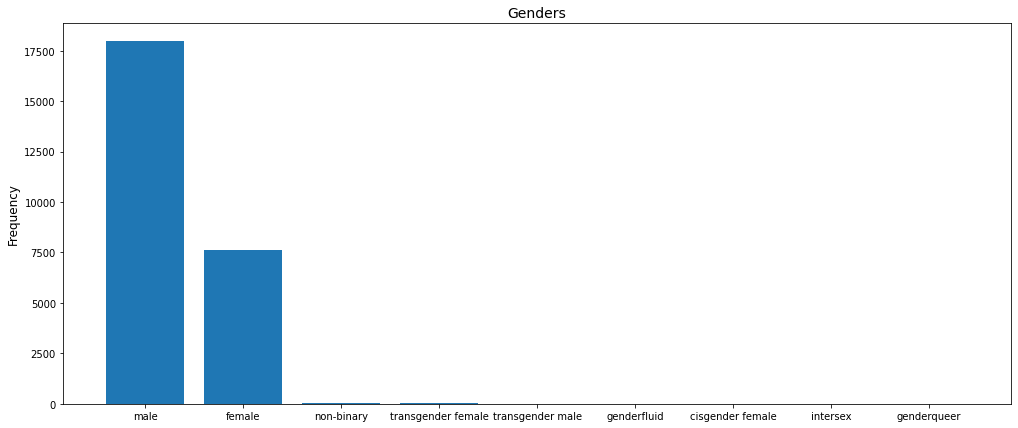

In [ ]:
# Visualisation of gender distribution
fig, ax = plt.subplots(figsize = (17,7))
ax.bar(convert(augmented_df["gender"]).value_counts().index,
        convert(augmented_df["gender"]).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Genders", size = 14)

As expected we can clearly see that minorities are almost negligible compared with the two main genders. Furthermore the male speakers are unsurprisingly more than double the females ones. 

In [ ]:
gender_expanded = augmented_df["gender"].apply(pd.Series)
gender_expanded = gender_expanded.rename(columns={0: 'sex', 1: 'self_identity'})
gender_expanded

,sex,self_identity
0,male,NaN
1,male,NaN
2,female,NaN
3,male,NaN
4,male,NaN
...,...,...
26065,male,NaN
26066,male,NaN
26067,female,NaN
26068,male,NaN


In [ ]:
augmented_df = pd.concat([augmented_df,gender_expanded], axis = 1)
augmented_df = augmented_df.drop(['gender'], axis = 1)
augmented_df.head()

,quoteID,quotation,speaker,nationality,qid,date,numOccurrences,urls,newspapers,sex,self_identity
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[United States of America],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian],male,NaN
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun],male,NaN
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[United States of America],Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times],female,NaN
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[United States of America],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun],male,NaN
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian],male,NaN


In [ ]:
males = augmented_df[[name == 'male' for name in augmented_df.sex]]
males.head()

,quoteID,quotation,speaker,nationality,qid,date,numOccurrences,urls,newspapers,sex,self_identity
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[United States of America],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian],male,NaN
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun],male,NaN
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[United States of America],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun],male,NaN
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian],male,NaN
5,2020-01-03-030623,I'm not in medieval times!,Robin Van Persie,[Kingdom of the Netherlands],Q2339,2020-01-03 22:32:10,94,[https://www.thesun.co.uk/sport/football/10666...,[The Sun],male,NaN


In [ ]:
females = augmented_df[[name == 'female' for name in augmented_df.sex]]
females.head()

,quoteID,quotation,speaker,nationality,qid,date,numOccurrences,urls,newspapers,sex,self_identity
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[United States of America],Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times],female,NaN
8,2020-04-08-075398,Your positivity on screen makes so many people...,HOLLY Willoughby,[United Kingdom],Q1395713,2020-04-08 07:10:04,1,[https://www.thesun.co.uk/tvandshowbiz/1135207...,[The Sun],female,NaN
12,2020-01-07-028035,I saw Snoop Dogg and given the fact I have met...,Nicole Scherzinger,[United States of America],Q167696,2020-01-07 22:30:07,1,[https://www.thesun.co.uk/tvandshowbiz/1069315...,[The Sun],female,NaN
26,2020-02-12-041734,I won't be staying by myself tonight.,Kelly Brook,[United Kingdom],Q255060,2020-02-12 22:34:08,104,[https://www.thesun.co.uk/tvandshowbiz/1095236...,[The Sun],female,NaN
29,2020-02-24-048695,"She's got as hammock, going back to my jungle ...",JACQUELINE Jossa,[United Kingdom],Q6120126,2020-02-24 12:16:46,1,[https://www.thesun.co.uk/tvandshowbiz/1102843...,[The Sun],female,NaN


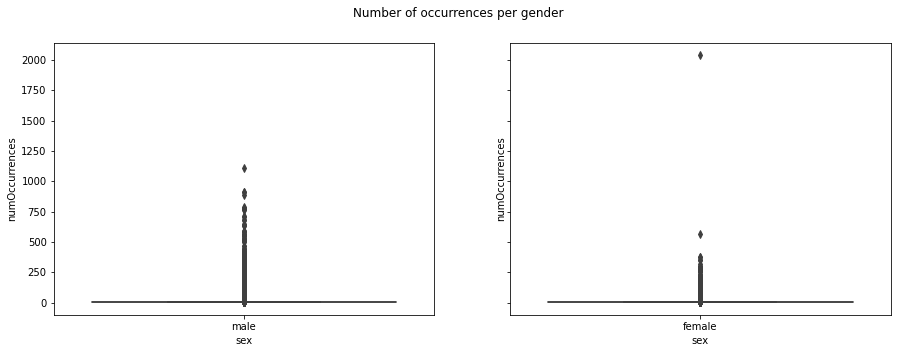

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1,2, sharey='row')
sns.boxplot(x='sex', y='numOccurrences', data = males, ax = axs[0])
sns.boxplot(x='sex', y='numOccurrences', data = females, ax = axs[1])
fig.suptitle('Number of occurrences per gender')
fig.set_size_inches(15,5)
plt.show()

In [ ]:
females.loc[females.numOccurrences >= 300]

,quoteID,quotation,speaker,nationality,qid,date,numOccurrences,urls,newspapers,sex,self_identity
2759,2020-01-24-061521,"Of course, this depends on whether this contin...",Chris Witty,[United States of America],Q273505,2020-01-24 16:03:09,354,[http://www.expressandstar.com/news/uk-news/20...,"[The Sun, The Sun, The Sun]",female,NaN
8012,2020-01-16-021077,gentlemen's club of politics.,Rebecca Long-Bailey,[United Kingdom],Q19979355,2020-01-16 22:31:27,375,[http://andoveradvertiser.co.uk/news/national/...,[The Sun],female,NaN
9484,2020-01-19-037423,That's really why we're here -- to pitch.,Duchess of Sussex,[United States of America],Q3304418,2020-01-19 00:00:00,304,[http://feeds.foxnews.com/~r/foxnews/entertain...,"[The Sun, The Sun, The Sun, The Sun]",female,NaN
10814,2020-01-24-108786,What we don't know is how far it's going to sp...,Chris Witty,[United States of America],Q273505,2020-01-24 17:01:37,352,[http://ardrossanherald.com/news/18185599.clea...,"[The Sun, The Sun, The Sun]",female,NaN
10997,2020-02-15-022996,I'm trying to find the words but I can't.,Laura Whitmore,[Ireland],Q6499556,2020-02-15 00:00:00,379,[http://femalefirst.co.uk/tv/news/caroline-fla...,"[The Sun, The Sun]",female,NaN
15169,2020-03-26-049143,protect the public and keep people safe.,Priti Patel,[United Kingdom],Q575733,2020-03-26 15:43:08,315,[http://www.expressandstar.com/news/uk-news/20...,[The Sun],female,NaN
15299,2020-02-02-030364,"My first thoughts are with the victims, our br...",Priti Patel,[United Kingdom],Q575733,2020-02-02 15:35:09,565,[https://globalnews.ca/news/6496241/stabbings-...,[The Sun],female,NaN
17635,2020-01-08-103116,work to become financially independent.,Duchess of Sussex,[United States of America],Q3304418,2020-01-08 00:00:00,2037,[http://kaaltv.com/news/prince-harry-meghan-st...,"[The Sun, The Guardian, The Sun]",female,NaN


In [ ]:
males.loc[males.numOccurrences >= 750]

,quoteID,quotation,speaker,nationality,qid,date,numOccurrences,urls,newspapers,sex,self_identity
1897,2020-01-07-005600,appears to be standing down.,President Donald Trump,[United States of America],Q22686,2020-01-07 23:52:00,759,[http://feeds.marketwatch.com/~r/marketwatch/b...,"[The Times, The Sun]",male,NaN
4209,2020-02-07-059825,make it impossible for me to do my job.,William Barr,[],Q16683338,2020-02-07 00:00:00,1105,[http://www.canindia.com/trump-should-stop-twe...,[The Guardian],male,NaN
5377,2020-02-04-073676,"So, we have to do everything today using avail...",Tedros Adhanom Ghebreyesus,[Ethiopia],Q16196017,2020-02-04 14:12:00,785,[https://www.wsbradio.com/lifestyles/atlanta-r...,[The Sun],male,NaN
7111,2020-01-02-015905,"He should have been taken out many years ago!,",President Donald Trump,[United States of America],Q22686,2020-01-02 15:27:00,767,[http://timescolonist.com/iran-vows-revenge-fo...,[The Sun],male,NaN
13195,2020-01-07-083106,"`We do not seek escalation or war, but will de...",Mohammad Javad Zarif,[Iran],Q10296812,2020-01-07 00:00:00,781,[http://feeds.foxnews.com/~r/foxnews/world/~3/...,"[The Sun, The Sun, The Sun, The Sun, The Sun, ...",male,NaN
19358,2020-01-21-011547,"By all indications, we are going on to New Ham...",Pete Buttigieg,[United States of America],Q7173106,2020-01-21 16:30:26,885,[https://www.inforum.com/news/government-and-p...,[The Guardian],male,NaN
20023,2020-01-02-068709,weirdos and misfits with odd skills.,Dominic Cummings,[United Kingdom],Q24572712,2020-01-02 00:00:00,773,[http://uk.investing.com/news/economy/wanted-w...,"[The Guardian, The Times, The Guardian]",male,NaN
20185,2020-01-31-079605,Terrorists seek to divide us and to destroy ou...,Sadiq Khan,[United Kingdom],Q334155,2020-01-31 00:00:00,914,[http://www.canindia.com/man-shot-dead-after-l...,[The Sun],male,NaN
21247,2020-03-23-054028,That's all -- these are the only reasons you s...,Boris Johnson,"[United States of America, United Kingdom]",Q180589,2020-03-23 17:01:37,907,[http://www.theglobeandmail.com/world/article-...,[The Sun],male,NaN
23724,2020-01-14-009869,bung a bob for a Big Ben bong.,Boris Johnson,"[United States of America, United Kingdom]",Q180589,2020-01-14 00:00:00,771,[http://www.foxnews.com/world/boris-johnson-ve...,"[The Times, The Sun, The Sun, The Sun]",male,NaN


### 4.3 Research ideas
<a id="ideas"></a>

### 4.4 Save final augmented dataframe as pickles
<a id="save_pickle"></a>